# Ensemble-based Post-Processing

Here we experiment with using an ensemble of outputs (from different segmentation routines) to assemble an overall estimate for OCT boundaries.

In [10]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import h5py

import sys, time
from datetime import datetime
import numpy as np
import pylab as plt
from scipy.io import loadmat, savemat

import GPy

import train_oct
import postproc_oct as ppo

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Loading Data

Load ground truth and ensemble estimates generated by Neil.  Dimensions of the latter are:

- 8 different CNN models
- 10 separate images
- 7 possible classes per pixel
- 512 rows
- 769 columns

In [2]:
# This is the original ground truth, if neede
#fn = '/Users/pekalmj1/Data/Tian_OCT/jbio201500239-sup-0003-Data-S1.mat'
#_,y_all,_,fold_id = train_oct.tian_load_data(fn)
#validation_fold = 4 
#y = y_all[fold_id == validation_fold, ...]

# ensemble estimates
f = np.load('Y_ensemble_results.npz')
print(f.keys())

Y_hat = f['Y_hat_raw_per_model']
X = f['X']
Y = f['Y']

print('y_hat shape:', Y_hat.shape)
print('X shape:', X.shape)
print('Y shape:', Y.shape)

['Y_hat_per_model', 'Y_hat_raw_ensemble_mean', 'Y_hat_ensemble_mean', 'Y', 'X', 'Y_hat_raw_per_model', 'Y_hat_ensemble_std']
y_hat shape: (8, 10, 7, 512, 768)
X shape: (10, 1, 512, 768)
Y shape: (10, 512, 768)


## Preliminary Analysis

Look at a subset of the data before solving a regression problem.

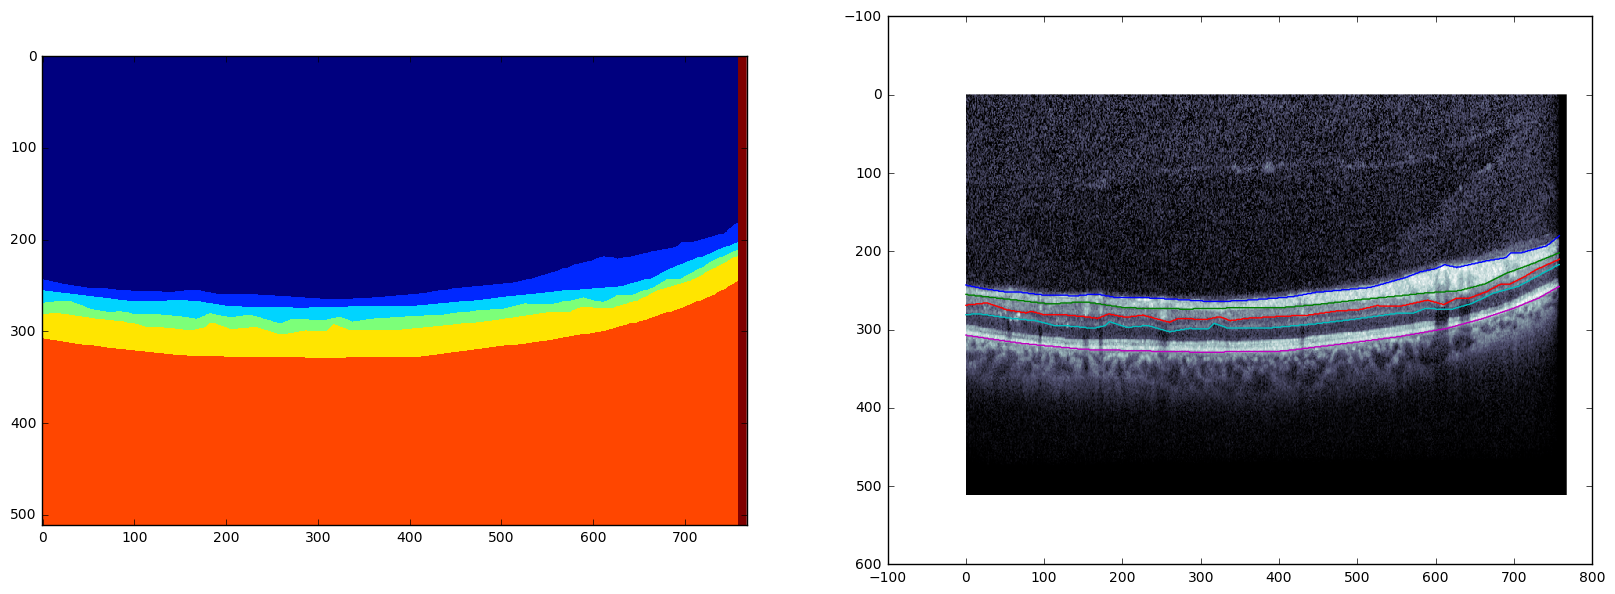

In [3]:
# Visualize data and ground truth

plt.figure(figsize=(20,10))

img_idx = 9 # also image 4

plt.subplot(1,2,1)
plt.imshow(Y[img_idx,:,:], interpolation='none');

plt.subplot(1,2,2)
plt.imshow(X[img_idx,0,:,:], interpolation='none', cmap='bone');  


for layer_id in range(5):
    true_boundary = ppo.get_class_transitions(Y[img_idx,:,:], layer_id)
    plt.plot(true_boundary[:,1], true_boundary[:,0], '-')

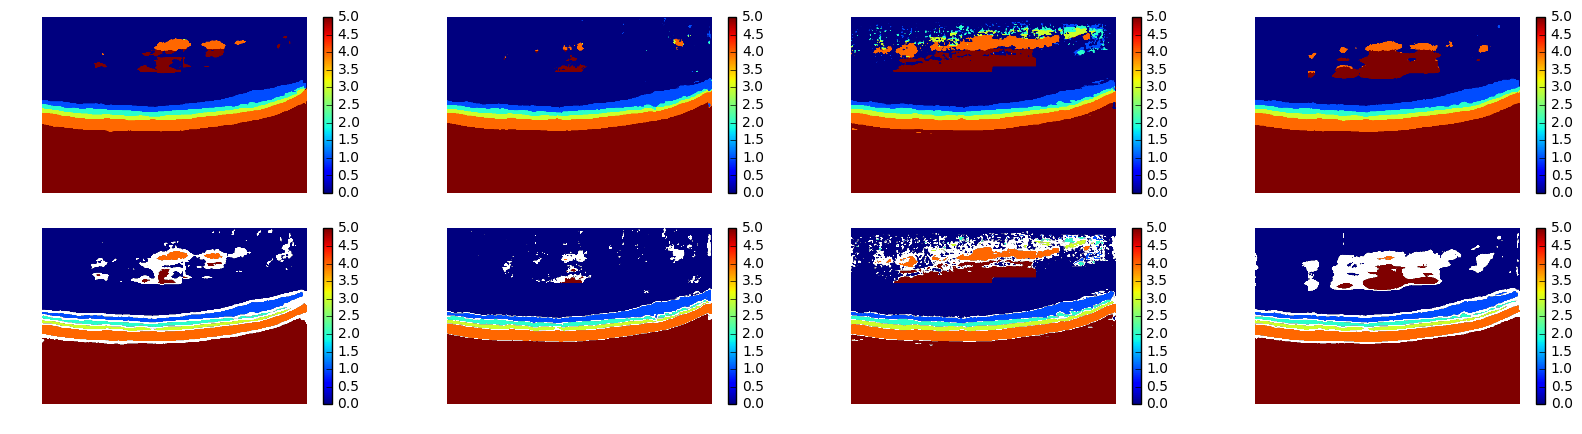

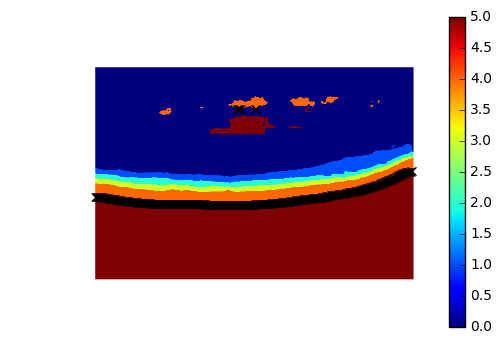

In [4]:
img_idx = 9
n = 4

# look at a few individual estimates
plt.figure(figsize=(20,5))
for model_idx in range(n):
    yi_prob = Y_hat[model_idx, img_idx, ...]
    yi_hat = np.argmax(yi_prob, axis=0)
    
    # show only the "high confidence" pixels/estimates
    mask = np.max(yi_prob, axis=0) > .8
    yi_hat_highconf = np.copy(yi_hat).astype(np.float32)
    yi_hat_highconf[~mask] = np.nan
     

    plt.subplot(2,n,model_idx+1);  
    plt.imshow(yi_hat);  plt.axis('off'); plt.colorbar()
    
    plt.subplot(2,n,n+model_idx+1);  
    plt.imshow(yi_hat_highconf);  plt.axis('off'); plt.colorbar()
    
# look at averaged result
#y_avg = np.mean(np.argmax(Y_hat[model_idx,...], axis=1), axis=0)
Y_hat_avg = np.argmax(np.sum(Y_hat, axis=0),axis=1)

plt.figure()

tmp_img = Y_hat_avg[img_idx,:,:]
tmp_points = ppo.get_class_transitions(tmp_img, 4)

plt.imshow(tmp_img);  plt.axis('off'); plt.colorbar()
plt.plot(tmp_points[:,1], tmp_points[:,0], 'kx')

plt.show()

## Boundary Regression

In [5]:
# Compute estimates using points across entire ensemble of models.
# We'll do the computation in this cell, and analysis in another
# (it takes a little while to compute all the estimates)

n_boundaries = 5
x_eval = np.arange(X.shape[-1])
Y_hat_all = np.zeros((X.shape[0], n_boundaries, X.shape[-1]))  #  (image, boundary_id, columns)

for img_idx in range(X.shape[0]):
    for boundary_idx in range(n_boundaries):
        # aggregate estimates across all models
        #estimates = [ppo.get_class_transitions(np.argmax(Y_hat[j, img_idx, ...], axis=0), boundary_idx)
        #                                       for j in range(Y_hat.shape[0])]
        #estimates = np.concatenate(estimates, axis=0)
        estimates = ppo.get_class_transitions(Y_hat_avg[img_idx,:,:], boundary_idx)
    
        # TODO: hyperparameter selection!
        if boundary_idx >= 4:
            kern = GPy.kern.RBF(input_dim=1, variance=5, lengthscale=100)
        else:
            kern = GPy.kern.RBF(input_dim=1, variance=20, lengthscale=80)

        tic = time.time()
        y_hat = ppo.boundary_regression_1d(estimates[:,1], estimates[:,0], x_eval, kern)
        Y_hat_all[img_idx, boundary_idx, :] = np.squeeze(y_hat)
        print('runtime for image %d, boundary %d: %0.2f sec' % (img_idx, boundary_idx, time.time() - tic))

np.savez('final_estimates.npz', Y_hat_all=Y_hat_all)
savemat('final_estimates.mat', {'Y_hat' : Y_hat_all})

runtime for image 0, boundary 0: 0.13 sec
runtime for image 0, boundary 1: 0.12 sec
runtime for image 0, boundary 2: 0.15 sec
runtime for image 0, boundary 3: 0.12 sec
runtime for image 0, boundary 4: 0.16 sec
runtime for image 1, boundary 0: 0.24 sec
runtime for image 1, boundary 1: 0.17 sec
runtime for image 1, boundary 2: 0.15 sec
runtime for image 1, boundary 3: 0.11 sec
runtime for image 1, boundary 4: 0.12 sec
runtime for image 2, boundary 0: 0.13 sec
runtime for image 2, boundary 1: 0.12 sec
runtime for image 2, boundary 2: 0.11 sec
runtime for image 2, boundary 3: 0.12 sec
runtime for image 2, boundary 4: 0.14 sec
runtime for image 3, boundary 0: 0.12 sec
runtime for image 3, boundary 1: 0.11 sec
runtime for image 3, boundary 2: 0.14 sec
runtime for image 3, boundary 3: 0.11 sec
runtime for image 3, boundary 4: 0.12 sec
runtime for image 4, boundary 0: 0.11 sec
runtime for image 4, boundary 1: 0.13 sec
runtime for image 4, boundary 2: 0.12 sec
runtime for image 4, boundary 3: 0

(10, 5, 768)
(10, 512, 768)
mean average error per boundary:  [ 1.76863608  1.4634083   1.24828111  1.18048217  2.95293228]
timestamp:  2017-08-15 20:06:15.653858


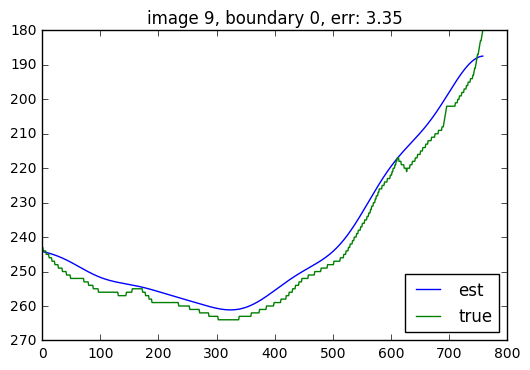

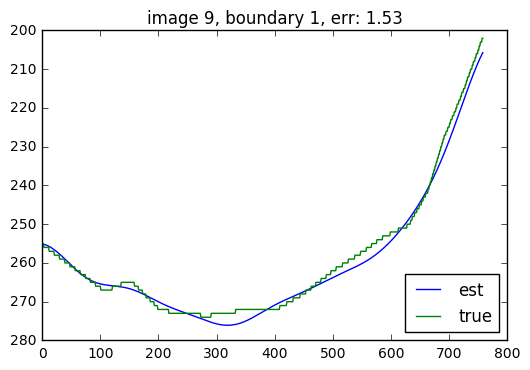

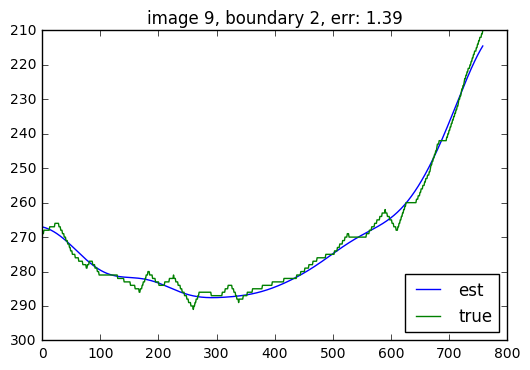

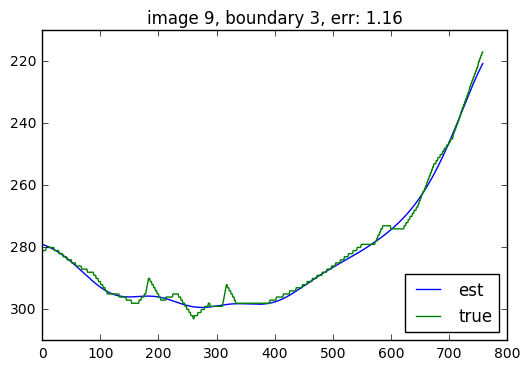

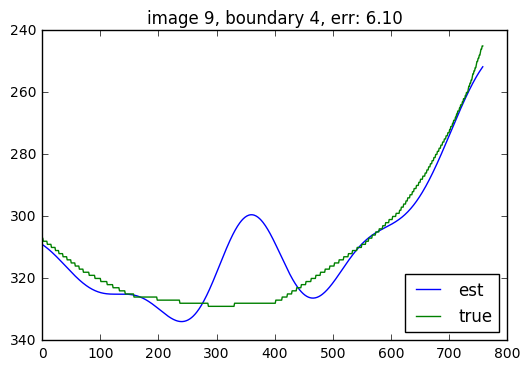

In [12]:
# restore saved estimates from above cell
if os.path.exists('final_estimates.npz'):
    tmp = np.load('final_estimates.npz')
    Y_hat_all = tmp['Y_hat_all']

print(Y_hat_all.shape)
print(Y.shape)


n_boundaries = 5

all_err = np.zeros((n_boundaries,))

for img_idx in range(Y.shape[0]):
    Y_i = Y[img_idx,:,:]

    for b_id in range(n_boundaries):
        # extract boundary from image.  
        # TODO: use original truth instead?
        y_true = ppo.get_class_transitions(Y_i, b_id)
        y_true_cols = y_true[:,1]
        y_true_rows = y_true[:,0]
    
        y_est = Y_hat_all[img_idx, b_id, :]
        y_est = y_est[y_true_cols]
    
        err = np.mean(np.abs(y_true_rows - y_est))
        all_err[b_id] += err
    
        # NOTE: as of this writing, image 4 is pretty bad
        #       Image 9 is even worse!
        if img_idx == 9:
            plt.figure()
            #plt.imshow(X[img_idx,0,...], interpolation='none', cmap='bone')
            plt.plot(y_true_cols, y_est, label='est')
            plt.plot(y_true_cols, y_true_rows, label='true')
            plt.gca().invert_yaxis()
            plt.legend(loc='lower right')
            plt.title('image %d, boundary %d, err: %0.2f'% (img_idx, b_id, err))

print('mean average error per boundary: ', all_err / Y.shape[0])
print('timestamp: ', datetime.now())